In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D,
SpatialDropout2D, RandomRotation, RandomTranslation, RandomFlip, RandomZoom, GaussianNoise, RandomContrast, RandomBrightness)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.mixed_precision import LossScaleOptimizer

from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

2025-03-30 17:28:27.458058: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 17:28:27.511212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743377307.540168   40101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743377307.549390   40101 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743377307.599349   40101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Sun Mar 30 17:29:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              7W /   70W |    5970MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

In [ ]:
# Define paths
train_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/train'
val_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/val'
test_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test'

# Load datasets
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

print(ds_train.class_names)

# Define augmentation pipeline (applies only during training)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15, fill_mode='reflect'),
    RandomTranslation(0.15, 0.15, fill_mode='reflect'),
    RandomZoom(0.1, fill_mode='reflect'),
    RandomContrast(0.2),
    RandomBrightness(0.2, value_range=(0,1)),
])

# Preprocessing function with augmentation (for training dataset)
def preprocess_image_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image, training=True)  # Apply augmentations
    return image, label

# Preprocessing function for validation & test (no augmentation)
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize only
    return image, label

# Apply preprocessing & augmentations
ds_train = ds_train.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize dataset performance
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


Found 79999 files belonging to 2 classes.
Found 20001 files belonging to 2 classes.
Found 7180 files belonging to 2 classes.
['0_non_cancer', '1_adenocarcinoma']


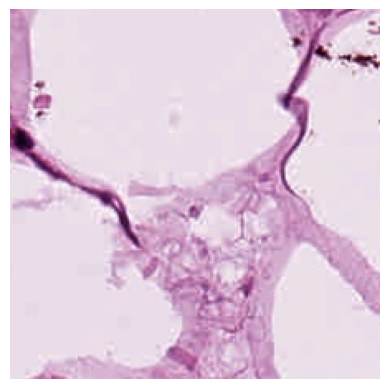

In [ ]:
# Sample image
dataset_path = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/train'
class_folders = os.listdir(dataset_path)

sample_img_path = os.path.join(dataset_path, class_folders[0], os.listdir(os.path.join(dataset_path, class_folders[0]))[0])
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#---Define model---
model = Sequential()

model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.1))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.1))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(AveragePooling2D((2,2)))
model.add(SpatialDropout2D(0.1))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(AveragePooling2D((2,2)))
model.add(SpatialDropout2D(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='swish', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='swish', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Display model summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_12            │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_13            │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,274,913 (4.86 MB)

 Trainable params: 1,272,993 (4.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Define class distribution
class_names = ['0_non_cancer', '1_adenocarcinoma']  # Ensure order matches ds_train.class_names
num_samples = [68546, 11453]  # Number of samples per class

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # Binary classes: 0 (0_non_cancer), 1 (1_adenocarcinoma)
    y=np.concatenate([np.zeros(num_samples[0]), np.ones(num_samples[1])])  # Labels
)

# Convert to dictionary format for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(0.5835424386543343), 1: np.float64(3.492491050379813)}


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=6,          # Stop training if val_loss doesn't improve for 6 epochs
    restore_best_weights=True  # Restore best model (avoid last overfitted epoch)
)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=2,  # If no improvement for 2 epochs
    min_lr=1e-6  # Don't let it go too low
)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='/mnt/c/Users/vienn/OneDrive/Escritorio/custom_model.keras',  # Save path
    monitor='val_loss',        # Track validation loss
    save_best_only=True,       # Save only when val_loss improves
    mode='min',                # 'min' for loss, 'max' for accuracy
)

In [ ]:
model.compile(
    optimizer = AdamW(learning_rate=0.001, weight_decay=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_val,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback]
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 263s 99ms/step - accuracy: 0.7731 - loss: 0.6192 - precision: 0.3869 - recall: 0.8410 - val_accuracy: 0.9022 - val_loss: 0.3175 - val_precision: 0.6034 - val_recall: 0.9239 - learning_rate: 0.0010
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 245s 95ms/step - accuracy: 0.9096 - loss: 0.3120 - precision: 0.6275 - recall: 0.9041 - val_accuracy: 0.9239 - val_loss: 0.2677 - val_precision: 0.6582 - val_recall: 0.9738 - learning_rate: 0.0010
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 246s 98ms/step - accuracy: 0.9248 - loss: 0.2691 - precision: 0.6730 - recall: 0.9209 - val_accuracy: 0.9152 - val_loss: 0.2731 - val_precision: 0.8112 - val_recall: 0.5311 - learning_rate: 0.0010
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 240s 96ms/step - accuracy: 0.9412 - loss: 0.2369 - precision: 0.7298 - recall: 0.9347 - val_accuracy: 0.8670 - val_loss: 0.3598 - val_precision: 0.5187 - val_recall: 0.9892 - learning_rate: 0.0010
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23

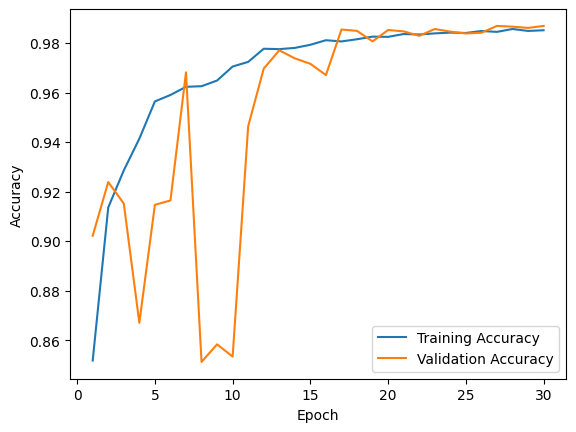

In [ ]:
# Model accuracy
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Accuracy')
plt.plot(epoch, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

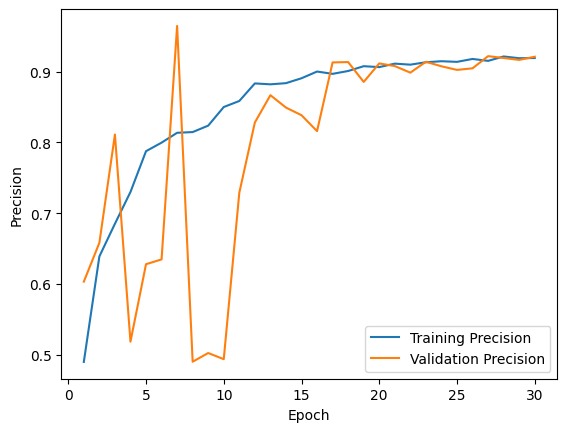

In [ ]:
# Model precision
accuracy_values = history.history['precision']
val_accuracy_values = history.history['val_precision']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Precision')
plt.plot(epoch, val_accuracy_values, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

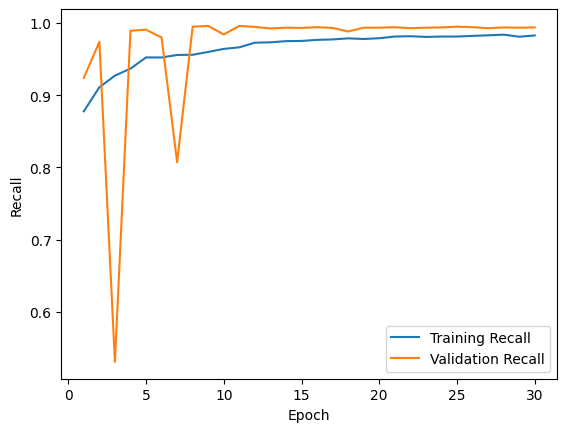

In [ ]:
# Model recall
accuracy_values = history.history['recall']
val_accuracy_values = history.history['val_recall']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Recall')
plt.plot(epoch, val_accuracy_values, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [16]:
best_model = tf.keras.models.load_model('/mnt/c/Users/vienn/OneDrive/Escritorio/Models/Custom/custom_model.keras')

In [17]:
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in ds_val], axis=0)
y_true = y_true.flatten().astype(int)  # Shape: (num_samples,)

# Generate predictions
y_pred_prob = best_model.predict(ds_val).flatten()  # Predicted probabilities
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Binary classes (0 or 1)

# Calculate metrics
f1 = f1_score(y_true, y_pred_class)
bal_acc = balanced_accuracy_score(y_true, y_pred_class)

print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

2025-03-30 17:48:58.612819: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
F1 Score: 0.9560
Balanced Accuracy: 0.9893


In [18]:
# Model evaluation
# Get all outputs
results = best_model.evaluate(ds_test)

test_loss, test_acc, test_precision, test_recall = results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9921 - loss: 0.0584 - precision: 0.1327 - recall: 0.1787
Test Loss: 0.0964
Test Accuracy: 0.9762
Test Precision: 0.8910
Test Recall: 0.9813


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Confusion Matrix (Test Set):
 [[5798  149]
 [  23 1210]]


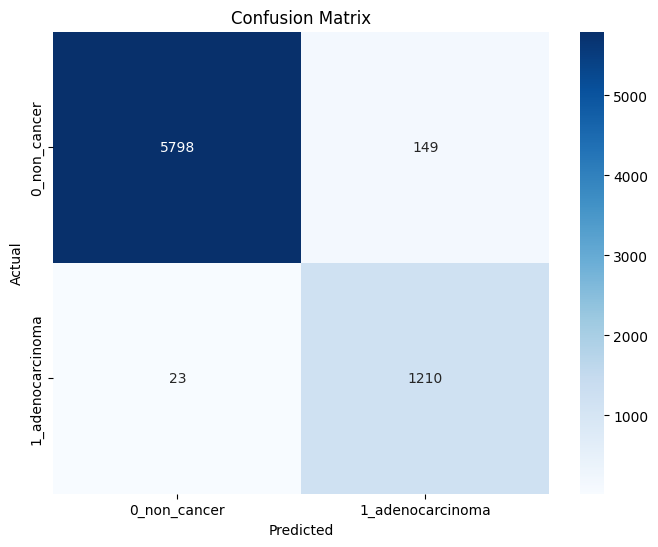

In [19]:
# Get true labels from test dataset
true_labels = np.concatenate([y.numpy() for _, y in ds_test], axis=0)

# Get model predictions
predictions = best_model.predict(ds_test)
predicted_labels = (predictions >= 0.5).astype(int)  # Threshold for binary classification

# Flatten both arrays for confusion matrix
true_labels = true_labels.flatten()
predicted_labels = predicted_labels.flatten()

# Get class names from dataset
class_names = ['0_non_cancer', '1_adenocarcinoma']


# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix (Test Set):\n", cm)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

  1/225 ━━━━━━━━━━━━━━━━━━━━ 52s 234ms/step

2025-03-30 17:52:06.196593: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step


2025-03-30 17:52:43.240019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test Recall: 0.9781
Test Precision: 0.9178
Test F1: 0.9470
Confusion Matrix (Test Set):
 [[5839  108]
 [  27 1206]]


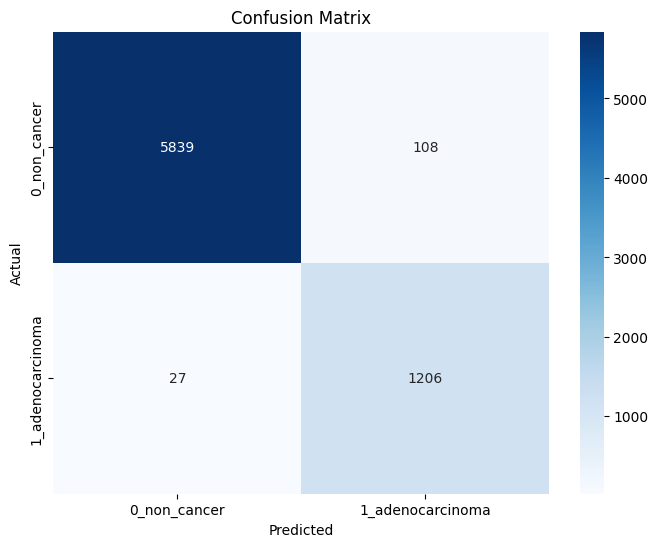

In [22]:
# Predict probabilities for test set
y_pred_prob_test = best_model.predict(ds_test).flatten()

y_true_test = np.concatenate([y.numpy() for _, y in ds_test], axis=0).astype(int)

best_threshold = 0.66
y_pred_class_tuned = (y_pred_prob_test >= best_threshold).astype(int)

# Calculate metrics
print(f"Test Recall: {recall_score(y_true_test, y_pred_class_tuned):.4f}")
print(f"Test Precision: {precision_score(y_true_test, y_pred_class_tuned):.4f}")
print(f"Test F1: {f1_score(y_true_test, y_pred_class_tuned):.4f}")

# Confusion matrix (optional)
cm = confusion_matrix(y_true_test, y_pred_class_tuned)
print("Confusion Matrix (Test Set):\n", cm)

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_class_tuned)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()